<a href="https://colab.research.google.com/github/KBE25/hotel_sentiment/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

# Business Understanding

# Data Understanding

## Data Preparation

In [84]:
!pip install emoji

In [85]:
!pip install symspellpy

In [86]:
#importing relevant libraries
import os
import re
import string
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import kagglehub

import spacy
import emoji

from symspellpy import SymSpell, Verbosity
import pkg_resources

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import spacy
import re
import emoji
from symspellpy import SymSpell, Verbosity
import pkg_resources

from sklearn.feature_extraction.text import TfidfVectorizer
import multiprocessing as mp
import numpy as np
from tqdm.auto import tqdm

# Suppress warnings
warnings.simplefilter(action="ignore", category=FutureWarning)




Data Preparation will contain the following parts:

### Data Acquisition

In [87]:
# Download latest dataset version
path = kagglehub.dataset_download("thedevastator/booking-com-hotel-reviews")


In [88]:
# Identify the path for the dataset
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/booking-com-hotel-reviews


In [89]:
# The path where the data is in the environment
base_dataset_directory = "/kaggle/input/booking-com-hotel-reviews"
csv_file_name = "booking_reviews copy.csv"
full_csv_path = os.path.join(base_dataset_directory, csv_file_name)
df = pd.read_csv(full_csv_path)

## Exploratory Data Analysis

### Evaluating the dataframe

This part of the project will contain an evaluation of the dataframa and the columns available in order to decide which ones to drop based on their relevance for the analysis.


In [90]:
df.shape

(26675, 16)

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26675 entries, 0 to 26674
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            26675 non-null  int64  
 1   review_title     26674 non-null  object 
 2   reviewed_at      26570 non-null  object 
 3   reviewed_by      26570 non-null  object 
 4   images           938 non-null    object 
 5   crawled_at       26386 non-null  object 
 6   url              26386 non-null  object 
 7   hotel_name       26386 non-null  object 
 8   hotel_url        26386 non-null  object 
 9   avg_rating       26386 non-null  float64
 10  nationality      26370 non-null  object 
 11  rating           26386 non-null  float64
 12  review_text      26386 non-null  object 
 13  raw_review_text  26202 non-null  object 
 14  tags             26202 non-null  object 
 15  meta             26202 non-null  object 
dtypes: float64(2), int64(1), object(13)
memory usage: 3.3+ MB


In [92]:
df.describe()

,index,avg_rating,rating
count,26675.000000,26386.000000,26386.000000
mean,13337.000000,8.449242,8.560669
std,7700.553552,0.716427,1.566554
min,0.000000,3.800000,1.000000
25%,6668.500000,8.100000,7.900000
50%,13337.000000,8.500000,9.000000
75%,20005.500000,8.900000,10.000000
max,26674.000000,10.000000,10.000000


In [93]:
df.head(-5)

,index,review_title,reviewed_at,reviewed_by,images,crawled_at,url,hotel_name,hotel_url,avg_rating,nationality,rating,review_text,raw_review_text,tags,meta
0,0,Exceptional,11 July 2021,Kyrylo,NaN,"07/20/2021, 01:09:27",https://www.booking.com/reviews/be/hotel/villa...,Villa Pura Vida,https://www.booking.com/hotel/be/villa-pura-vi...,9.7,Poland,10.0,"Everything was perfect! Quite, cozy place to r...","<p class=""review_pos ""><svg aria-label=""Positi...",Business trip~Solo traveller~Junior Suite~Stay...,"{'language': 'en-gb', 'source': 'https://www.b..."
1,1,I highly recommend this b&b! We enjoyed it a lot!,24 November 2019,Dimitri,NaN,"07/20/2021, 01:09:27",https://www.booking.com/reviews/be/hotel/villa...,Villa Pura Vida,https://www.booking.com/hotel/be/villa-pura-vi...,9.7,Belgium,9.0,Very friendly host and perfect breakfast!,"<p class=""review_pos ""><svg aria-label=""Positi...",Leisure trip~Couple~Deluxe Suite~Stayed 1 nigh...,"{'language': 'en-gb', 'source': 'https://www.b..."
2,2,Exceptional,3 January 2020,Virginia,NaN,"07/20/2021, 01:09:27",https://www.booking.com/reviews/be/hotel/hydro...,Hydro Palace Apartment,https://www.booking.com/hotel/be/hydro-palace....,9.2,United Kingdom,10.0,It was just what we wanted for a week by the b...,"<p class=""review_neg ""><svg aria-label=""Negati...",Leisure trip~Couple~Apartment with Sea View~St...,"{'language': 'en-gb', 'source': 'https://www.b..."
3,3,My stay in the house was a experiencing bliss ...,8 September 2019,Kannan,NaN,"07/20/2021, 01:09:28",https://www.booking.com/reviews/be/hotel/villa...,Villa Pura Vida,https://www.booking.com/hotel/be/villa-pura-vi...,9.7,Netherlands,10.0,My stay in the house was a experiencing bliss ...,"<p class=""review_pos ""><svg aria-label=""Positi...",Business trip~Solo traveller~Junior Suite~Stay...,"{'language': 'en-gb', 'source': 'https://www.b..."
4,4,One bedroom apartment with wonderful view and ...,23 June 2019,Sue,https://cf.bstatic.com/xdata/images/xphoto/squ...,"07/20/2021, 01:09:28",https://www.booking.com/reviews/be/hotel/hydro...,Hydro Palace Apartment,https://www.booking.com/hotel/be/hydro-palace....,9.2,South Africa,9.2,The building itself has a very musty smell in ...,"<p class=""review_neg ""><svg aria-label=""Negati...",Leisure trip~People with friends~Apartment wit...,"{'language': 'en-gb', 'source': 'https://www.b..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26665,26665,Superb,14 September 2018,Ann,NaN,"07/20/2021, 02:15:50",https://www.booking.com/reviews/be/hotel/oudhu...,Martin's Relais,https://www.booking.com/hotel/be/oudhuisamster...,8.6,United Kingdom,9.2,"The expensive price of breakfast.,\n\nFabulous...","<p class=""review_neg ""><svg aria-label=""Negati...",Leisure trip~Couple~Comfort Double Room with C...,"{'language': 'en-gb', 'source': 'https://www.b..."
26666,26666,Fabulous,1 October 2018,Hamed,NaN,"07/20/2021, 02:15:50",https://www.booking.com/reviews/be/hotel/warwi...,Warwick Brussels - Grand Place,https://www.booking.com/hotel/be/warwick-bruss...,8.2,Iran,8.8,"Best location,\n\nExcelent location","<p class=""review_neg ""><svg aria-label=""Negati...",Leisure trip~Couple~Classic Queen Room~Stayed ...,"{'language': 'en-gb', 'source': 'https://www.b..."
26667,26667,Exceptional,17 March 2020,Olya,NaN,"07/20/2021, 02:15:50",https://www.booking.com/reviews/be/hotel/winds...,Logies Windsor,https://www.booking.com/hotel/be/windsor-castl...,8.5,Belgium,10.0,"Everything was great. thank you!,\n\nThe guest...","<p class=""review_neg ""><svg aria-label=""Negati...",Leisure trip~Solo traveller~Double Room~Stayed...,"{'language': 'en-gb', 'source': 'https://www.b..."
26668,26668,Superb,8 October 2019,Subodh,NaN,"07/20/2021, 02:15:50",https://www.booking.com/reviews/be/hotel/best-...,Hotel Ter Elst,https://www.booking.com/hotel/be/best-western-...,8.3,Germany,9.0,There are no comments available for this review,"<p class=""review_none""><em>There are no commen...",Business trip~Solo traveller~Standa

In [94]:
# Handle potential NaN values for comparison between raw_review_text and review_text
# For this I fill NaN with a placeholder string to avoid issues, as NaN != NaN
df_temp = df.fillna({'review_text': '', 'raw_review_text': ''}).copy()

# Count how many rows have identical content
identical_reviews = (df_temp['review_text'] == df_temp['raw_review_text']).sum()
# Only count rows where both are non-null
total_reviews_comparable = len(df_temp) - df_temp['review_text'].isnull().sum() - df_temp['raw_review_text'].isnull().sum()

print(f"Number of reviews where 'review_text' and 'raw_review_text' are identical (after filling NaN): {identical_reviews}")
print(f"Total comparable reviews (where both are non-null): {total_reviews_comparable}")
print(f"Percentage identical: {((identical_reviews / total_reviews_comparable) * 100):.2f}%")

Number of reviews where 'review_text' and 'raw_review_text' are identical (after filling NaN): 289
Total comparable reviews (where both are non-null): 26675
Percentage identical: 1.08%


Given that only 1.08% of review_text and raw_review_text are identical,this indicates significant differences between the two. Because of this it's crucial to understand the nature of these disparities before deciding which column to retain for further analysis.

In [95]:
# Calculate the length of 'review_text' and 'raw_review_text'
df_temp['review_text_len'] = df_temp['review_text'].apply(len)
df_temp['raw_review_text_len'] = df_temp['raw_review_text'].apply(len)

# Look at descriptive statistics of lengths
print("\nDescriptive statistics for 'review_text' length:")
print(df_temp['review_text_len'].describe())

print("\nDescriptive statistics for 'raw_review_text' length:")
print(df_temp['raw_review_text_len'].describe())

# Check for rows where one is significantly longer than the other (e.g., >20 characters difference)
print("\n--- Examples where review_text is MUCH longer (diff > 20 chars) ---")
longer_review_text_diff = df_temp[df_temp['review_text_len'] - df_temp['raw_review_text_len'] > 20]
print(f"Number of such rows: {len(longer_review_text_diff)}")
if not longer_review_text_diff.empty:
    print(longer_review_text_diff[['review_text', 'raw_review_text']].head(3).to_string())

print("\n--- Examples where raw_review_text is MUCH longer (diff > 20 chars) ---")
longer_raw_review_text_diff = df_temp[df_temp['raw_review_text_len'] - df_temp['review_text_len'] > 20]
print(f"Number of such rows: {len(longer_raw_review_text_diff)}")
if not longer_raw_review_text_diff.empty:
    print(longer_raw_review_text_diff[['review_text', 'raw_review_text']].head(3).to_string())


Descriptive statistics for 'review_text' length:
count    26675.000000
mean       160.166111
std        201.930996
min          0.000000
25%         47.000000
50%         78.000000
75%        204.000000
max       3368.000000
Name: review_text_len, dtype: float64

Descriptive statistics for 'raw_review_text' length:
count    26675.000000
mean       782.758163
std        547.427211
min          0.000000
25%         83.000000
50%        837.000000
75%       1193.000000
max       4392.000000
Name: raw_review_text_len, dtype: float64

--- Examples where review_text is MUCH longer (diff > 20 chars) ---
Number of such rows: 149
                                                                                           review_text raw_review_text
54   Very clean and warm chalet. Friendly hosts willing to help and provide everything that is needed.                
75                                                                           Vicinity to train station                
241          

In [96]:
# Find a few rows where they are different (and both non-empty) for manual inspection
diff_reviews_sample = df_temp[(df_temp['review_text'] != df_temp['raw_review_text']) &
                              (df_temp['review_text'] != '') & (df_temp['raw_review_text'] != '')].sample(min(5, len(df_temp))).copy()

print("\n--- Detailed Examples of Differences (5 random samples) ---")
for index, row in diff_reviews_sample.iterrows():
    print(f"\nRow Index: {index}")
    print(f"review_text:     '{row['review_text']}'")
    print(f"raw_review_text: '{row['raw_review_text']}'")
    print("-" * 50)


--- Detailed Examples of Differences (5 random samples) ---

Row Index: 21863
review_text:     'The room was so very smal,

Peronal was friendly and helpful. The room was clean. The location is just perfect.'
raw_review_text: '<p class="review_neg "><svg aria-label="Negative point" class="bk-icon -fonticon-removecircle review_item_icon" fill="#BDBDBD" height="14" role="img" width="14" viewbox="0 0 32 32" aria-hidden="true" focusable="false"><path d="m16 0c-8.84 0-16 7.16-16 16s7.16 16 16 16 16-7.16 16-16-7.16-16-16-16zm8 17.6h-16v-3.2h16z"></path></svg><span itemprop="reviewBody">The room was so very smal</span></p>,<p class="review_pos "><svg aria-label="Positive point" class="bk-icon -fonticon-plus review_item_icon" fill="#008009" height="14" role="img" width="14" viewbox="0 0 32 32" aria-hidden="true" focusable="false">
  <path d="M32 16c0 8.836-7.162 16-16 16-8.834 0-16-5.74-16-16C0 6.451 7.166 0 16 0c8.838 0 16 7.162 16 16zm-6.4-2.585c0-.369-.031-.616-.4-.616h-5.998V7.018c0-.369-

In [97]:
# Displaying the first few non-null entries
print("First 10 non-null entries in 'meta' column:")
print(df['meta'].dropna().head(10).tolist())

# Displaying a random sample
print("\n10 random non-null entries in 'meta' column:")
print(df['meta'].dropna().sample(10).tolist())

First 10 non-null entries in 'meta' column:
["{'language': 'en-gb', 'source': 'https://www.booking.com'}", "{'language': 'en-gb', 'source': 'https://www.booking.com'}", "{'language': 'en-gb', 'source': 'https://www.booking.com'}", "{'language': 'en-gb', 'source': 'https://www.booking.com'}", "{'language': 'en-gb', 'source': 'https://www.booking.com'}", "{'language': 'en-gb', 'source': 'https://www.booking.com'}", "{'language': 'en-gb', 'source': 'https://www.booking.com'}", "{'language': 'en-gb', 'source': 'https://www.booking.com'}", "{'language': 'en-gb', 'source': 'https://www.booking.com'}", "{'language': 'en-gb', 'source': 'https://www.booking.com'}"]

10 random non-null entries in 'meta' column:
["{'language': 'en-gb', 'source': 'https://www.booking.com'}", "{'language': 'en-gb', 'source': 'https://www.booking.com'}", "{'language': 'en-gb', 'source': 'https://www.booking.com'}", "{'language': 'en-gb', 'source': 'https://www.booking.com'}", "{'language': 'en-gb', 'source': 'https:

Based on the above checks, I will be dropping the following columns that are not relevant for this analysis:

1. index: Redundant DataFrame index.

2. images: Too sparse, and image analysis is out of scope for this analysis as we are using text for hotel rating prediction.

3. crawled_at: Irrelevant timestamp for this analysis as this is when the review was crawled from the site.

4. url: Unique identifier for the review page, no predictive power.

5. hotel_url: Unique identifier for the hotel page, but this becomes redundant if hotel_name or hotel_id is used.

6. meta: content is consistently redundant, specifying 'en-gb' language and 'booking.com' source, and therefore provides no unique or discriminative information for this analysis.

7. review_text: as it seems to be a simplified version of raw_review_text and is better to keep the columns with full information to better extract richer features for the analysis.

In [98]:
# Dropping unnecesary columns
# Create a list of columns to drop
columns_to_drop = ['index', 'images', 'crawled_at', 'url', 'hotel_url', 'meta', 'review_text']

# Perform the drop operation
df_cleaned = df.drop(columns=columns_to_drop, errors='ignore')

# Inspecting new dataframe
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26675 entries, 0 to 26674
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   review_title     26674 non-null  object 
 1   reviewed_at      26570 non-null  object 
 2   reviewed_by      26570 non-null  object 
 3   hotel_name       26386 non-null  object 
 4   avg_rating       26386 non-null  float64
 5   nationality      26370 non-null  object 
 6   rating           26386 non-null  float64
 7   raw_review_text  26202 non-null  object 
 8   tags             26202 non-null  object 
dtypes: float64(2), object(7)
memory usage: 1.8+ MB


In [99]:
#Initial Missing Value Overview
df_cleaned.isnull().sum()

,0
review_title,1
reviewed_at,105
reviewed_by,105
hotel_name,289
avg_rating,289
nationality,305
rating,289
raw_review_text,473
tags,473


Before analyzing the distribution of our target variable 'rating', it's crucial to address its missing values. As observed, the rating column contains 289 missing entries. For supervised learning, every data point used in the target distribution analysis and model training must have a defined target value.

Therefore, I made the decision to drop all rows where the rating value was NaN. This ensures the integrity of our target variable. Given this drop accounts for only about 1.08% of our total dataset, the data loss is minimal and justified to maintain data quality for supervised learning.

In [100]:
# Dropping NAN from target variable 'rating'
df_cleaned = df_cleaned.dropna(subset=['rating']).copy()

In [101]:
# Additional Missing Value Overview
df_cleaned.isnull().sum()

,0
review_title,1
reviewed_at,0
reviewed_by,0
hotel_name,0
avg_rating,0
nationality,16
rating,0
raw_review_text,184
tags,184


The additional missing values will be managed later in the Data processing part.

### Target Variable Distribution Analysis

For this project, the target variable is rating, which mean that I have two different ways to approach the solution:

1.   A regression approach by predicting the exact rating
2.   A classification approach by converting rating to sentiment categories

So in this part, I will conduct a distribution analysis for both, since I have a numerical rating from the Booking.com data I will first approach a solution with a regression problem to predict a numerical rating and then explore the sentiment classification as an alternative.

#### Rating Prediction (Regression Problem)

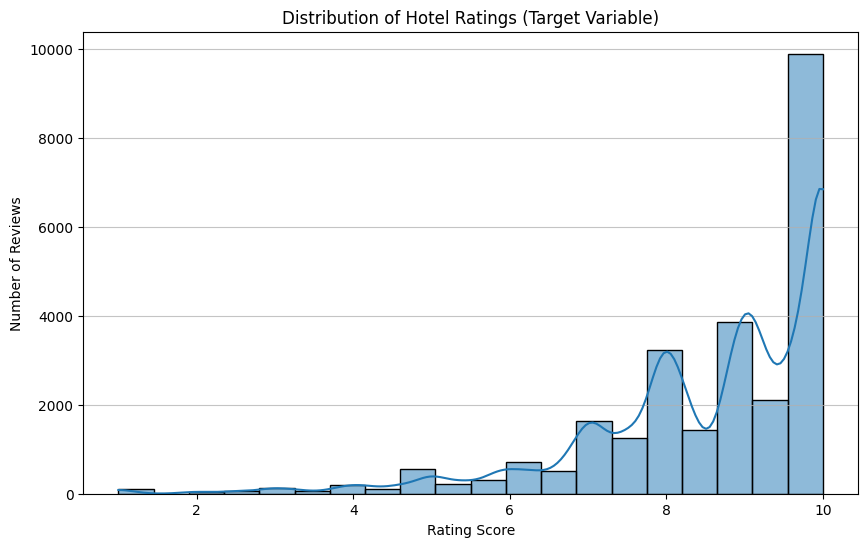


Descriptive Statistics for 'rating':
count    26386.000000
mean         8.560669
std          1.566554
min          1.000000
25%          7.900000
50%          9.000000
75%         10.000000
max         10.000000
Name: rating, dtype: float64

Unique values in 'rating':
[10.   9.   9.2  8.3  7.5  8.   9.6  8.8  7.9  7.   7.1  6.   6.7  5.
  9.5  2.   3.   3.8  4.2  5.8  5.4  1.   4.6  6.3  8.5  3.3  2.9  4.
  2.5  4.5  5.5  8.1  3.5  9.4  6.5  6.9]

Value counts for 'rating':
rating
1.0       95
2.0       44
2.5       55
2.9       40
3.0       78
3.3       67
3.5        1
3.8       81
4.0      104
4.2      101
4.5        6
4.6      162
5.0      384
5.4      228
5.5       12
5.8      294
6.0      305
6.3      400
6.5       10
6.7      512
6.9        1
7.0      907
7.1      735
7.5     1242
7.9     1141
8.0     2086
8.1        1
8.3     1393
8.5       33
8.8     1538
9.0     2319
9.2     2050
9.4        8
9.5       57
9.6     2463
10.0    7433
Name: count, dtype: int64


In [102]:
#Creating an histogram for the target variable 'rating'
rating_column_name = 'rating'

plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned[rating_column_name], bins=20, kde=True) # Adjust bins if rating scale is very small/large
plt.title(f'Distribution of Hotel Ratings (Target Variable)')
plt.xlabel('Rating Score')
plt.ylabel('Number of Reviews')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Get descriptive statistics for the varible 'rating'
print(f"\nDescriptive Statistics for '{rating_column_name}':")
print(df_cleaned[rating_column_name].describe())

# Check for specific unique values (e.g., 1-10)
if df_cleaned[rating_column_name].dtype in ['int64', 'float64']:
    print(f"\nUnique values in '{rating_column_name}':")
    print(df_cleaned[rating_column_name].unique())
    print(f"\nValue counts for '{rating_column_name}':")
    print(df_cleaned[rating_column_name].value_counts().sort_index())

Based on the histogram, the key findings are that the 'rating' column is a numerical target with ample data (26386 non-null entries). However, it exhibits a strong positive skew, with a mean of 8.56, and over 75% of ratings are 7.9 or higher, making lower ratings significantly sparse.

This skew will cause regression models to be biased towards predicting higher ratings, potentially performing poorly on and underrepresenting the crucial, but rare, lower (negative) ratings.

Moving forward with the regression to predict the rating will mean that:

*   I will need to prioritize MAE/RMSE for evaluation and analyze errors across rating ranges.
*  Employ robust regression models like Gradient Boosting Machines (XGBoost, LightGBM).
*   Focus feature engineering on attributes indicative of negative sentiment to aid prediction of sparse low ratings.
*   Consider converting to a classification problem by binning ratings if direct regression proves too challenging.

#### Sentiment Classification (Classification Problem derived from rating)

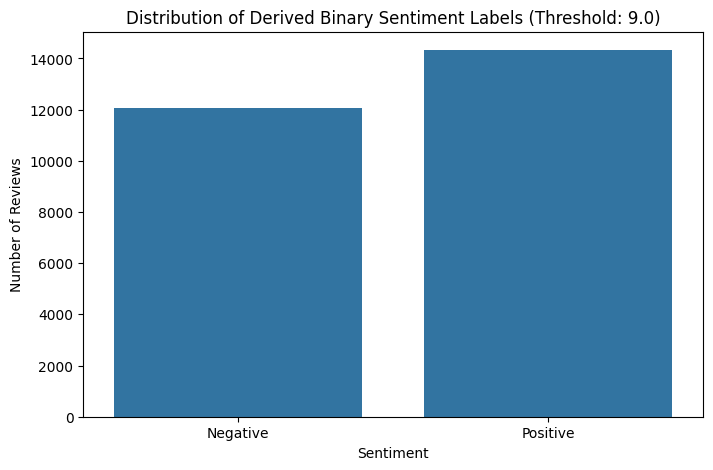


Derived Binary Sentiment Label Counts:
sentiment_label
Positive    14330
Negative    12056
Name: count, dtype: int64

Derived Binary Sentiment Label Proportions:
sentiment_label
Positive    54.31
Negative    45.69
Name: proportion, dtype: float64


In [103]:
# Define a function to categorize ratings into sentiments
# The split for the binary classification was done to try to keep a 50/50 split
def derive_binary_sentiment(rating):
    if rating >= 9.0:
        return 'Positive'
    else:
        return 'Negative'

# Create the new binary sentiment column
df_cleaned['sentiment_label'] = df_cleaned[rating_column_name].apply(derive_binary_sentiment)

#df_classification['sentiment_label'] = df_classification['rating'].apply(derive_binary_sentiment)

# Display the distribution of sentiment labels
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment_label', data=df_cleaned, order=['Negative', 'Positive'])
plt.title('Distribution of Derived Binary Sentiment Labels (Threshold: 9.0)')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

# Print counts and percentages to quantify imbalance
sentiment_counts = df_cleaned['sentiment_label'].value_counts()
print("\nDerived Binary Sentiment Label Counts:")
print(sentiment_counts)
print("\nDerived Binary Sentiment Label Proportions:")
print((df_cleaned['sentiment_label'].value_counts(normalize=True) * 100).round(2))


Your rating data was effectively transformed into a well-balanced binary classification target (Positive: 53.72%, Negative: 46.28%) using the rating 9.0 as a threshold. This near-even split mitigates class imbalance issues, aiding robust classifier training and evaluation.

The limitations of this split is that, the 9.0 threshold is arbitrary, leading to a loss of original rating granularity where diverse dissatisfaction levels are grouped. Reviews just below 9.0 are categorized with truly negative ones, potentially misrepresenting nuanced sentiment. "Neutral" reviews might also fall into "Negative" based purely on score.

To address the limitations, I will be performing a boundary analysis during model evaluation to understand misclassifications near the 9.0 mark as well a conducting detailed error analysis on miscategorized reviews.

## Data Processing

### Handling missing values

In [104]:
# Current missing values
df_cleaned.isnull().sum()

,0
review_title,1
reviewed_at,0
reviewed_by,0
hotel_name,0
avg_rating,0
nationality,16
rating,0
raw_review_text,184
tags,184
sentiment_label,0


We will manage the the missing values for 'review_title', 'nationality', 'raw_review_text' and 'tags' in the following way:

1.  review_title: I will add a placeholder "No Title" to preserve data. This approach is ideal because only one value is missing, and mean/median/mode imputation isn't suitable for text.
2.  nationality: I will fill in the NaNs with the mode so the most frequent nationality. Using the mode is a common and  reasonable approach for categorical features as it preserves the distribution of the existing data as much as possible by assuming the missing values are most likely to belong to the most common category. While it might introduce a slight bias towards the mode, for a small number of missing values (16 in this case), the impact will be minimal.

3.  raw_review_text: I will add a placeholder in this case an empty string. In this case an empty String '' is the best option as in an NLP pipeline this will naturally result in no tokens or zero vectors, which is the correct representation for an absent review.

4.  tags: I will add a placeholder in this case an empty string.


In [105]:
# Review title
df_cleaned['review_title'].fillna('No Title', inplace=True)

# Nationality
most_frequent_nationality = df_cleaned['nationality'].mode()[0]
df_cleaned['nationality'].fillna(most_frequent_nationality, inplace=True)

# Raw_review_text
df_cleaned['raw_review_text'].fillna('', inplace=True)

# Tags
df_cleaned['tags'].fillna('', inplace=True)

In [106]:
# Validating that the missing values were handled
df_cleaned.isnull().sum()

,0
review_title,0
reviewed_at,0
reviewed_by,0
hotel_name,0
avg_rating,0
nationality,0
rating,0
raw_review_text,0
tags,0
sentiment_label,0


### Feature Engineering from Structured Data

The goal of this part is to extract more information from existing numerical and categorical features, especially time-related ones, to potentially improve model performance or provide deeper insights.

#### Step 1: Convert reviewed_at to Datetime object

Convert reviewed_at in df_cleaned to a pandas datetime object as this allows easy extraction of year, month, day, day of week and facilitates date arithmetic.

In [107]:
# Convert to datetime
df_cleaned['reviewed_at'] = pd.to_datetime(df_cleaned['reviewed_at'])


In [108]:
# Now that reviewed_at is a datetime object, I can easily extract various time-based features.
# Seasonality: Month, quarter, and day of week can capture seasonal trends in reviews.
# Temporal Trends: Year can capture long-term trends or changes.
# Recency: review_age_days

# Basic features to create
df_cleaned['review_year'] = df_cleaned['reviewed_at'].dt.year
df_cleaned['review_month'] = df_cleaned['reviewed_at'].dt.month
df_cleaned['review_day'] = df_cleaned['reviewed_at'].dt.day
df_cleaned['review_day_of_week'] = df_cleaned['reviewed_at'].dt.dayofweek # Monday=0, Sunday=6
df_cleaned['review_quarter'] = df_cleaned['reviewed_at'].dt.quarter

# Age relative to the latest review date in the dataset
latest_review_date = df_cleaned['reviewed_at'].max()
df_cleaned['review_age_days'] = (latest_review_date - df_cleaned['reviewed_at']).dt.days

print("\nDataFrame after adding time-based features:")
print(df_cleaned[['reviewed_at', 'review_year', 'review_month', 'review_day', 'review_day_of_week', 'review_quarter', 'review_age_days']].head())


DataFrame after adding time-based features:
  reviewed_at  review_year  review_month  review_day  review_day_of_week  \
0  2021-07-11         2021             7          11                   6   
1  2019-11-24         2019            11          24                   6   
2  2020-01-03         2020             1           3                   4   
3  2019-09-08         2019             9           8                   6   
4  2019-06-23         2019             6          23                   6   

   review_quarter  review_age_days  
0               3                8  
1               4              603  
2               1              563  
3               3              680  
4               2              757  


#### Step 2: Aggregation Features

Reviewer centric metrics?

In [ ]:
#reviewer_stats = df_cleaned.groupby('reviewed_by').agg(reviewer_total_reviews=('reviewed_by', 'count'),reviewer_avg_rating=('rating', 'mean')).reset_index()
#df_cleaned = pd.merge(df_cleaned, reviewer_stats, on='reviewed_by', how='left')

#print("\nDataFrame after adding aggregation features:")
#print(df_cleaned[['hotel_name', 'rating', 'hotel_avg_rating', 'hotel_total_reviews',
#          'reviewed_by', 'reviewer_total_reviews', 'reviewer_avg_rating']].head())